In [19]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from os.path import join

import energyflow as ef
import h5py
import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf
from sklearn.neighbors import KernelDensity
import pandas as pd

In [21]:
# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import (
    calculate_all_wasserstein_metrics,
    inverse_normalize_tensor,
    normalize_tensor,
)
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, plot_data, prepare_data_for_plotting

apply_mpl_styles()

In [22]:
from jetnet.evaluation import w1efp, w1m, w1p
from src.utils.jet_substructure import dump_hlvs
from src.data.components.metrics import wasserstein_distance_batched
from src.utils.plotting import (
    plot_substructure,
    plot_full_substructure,
)

In [23]:
# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

In [24]:
data_folder = os.environ.get("DATA_DIR")

# load data

In [57]:
path_preds = "/beegfs/desy/user/ewencedr/data/lhco/preds.h5"
with h5py.File(path_preds, "r") as f:
    pred = f["preds"][:]
    semi_labels = f["semi_labels"][:]
    sample_mjj = f["mjj"][:]
    sample_j = f["sample_j"][:]
    sample_p = f["sample_p"][:]

In [58]:
print(sample_p.shape)

(222351, 2, 279, 3)


In [59]:
#revert pre-processing
def LoadJson(file_name):
    import json,yaml
    JSONPATH = os.path.join(file_name)
    return yaml.safe_load(open(JSONPATH))
data_dict = LoadJson('/home/ewencedr/LHCO_diffusion/scripts/preprocessing_279.json')
batch_size = sample_p.shape[0]
num_part = sample_p.shape[2]
sample_p=sample_p.reshape(-1,sample_p.shape[-1])
mask = np.expand_dims(sample_p[:,0]!=0,-1)
sample_p = sample_p*data_dict['std_particle'] + data_dict['mean_particle']

sample_p[:,0] = 1.0 - np.exp(sample_p[:,0])
sample_p[:,0] = np.clip(sample_p[:,0],2.5349376295699686e-05,1.0) #apply min pt cut
sample_p = (sample_p*mask).reshape(batch_size,2,num_part,-1)
print(sample_p.shape)

(222351, 2, 279, 3)


In [60]:
pred_bool = pred > 0.5
pred_bool = pred_bool.squeeze()

In [61]:
correct = pred_bool == semi_labels
accuracy = np.sum(correct) / len(correct)
print(f"ACC: {accuracy}")

ACC: 0.8391687017373433


In [62]:
print(np.sum(correct))
print(np.sum(~correct))

186590
35761


In [63]:
correct_j = sample_j[correct]
false_j = sample_j[~correct]
correct_mjj = sample_mjj[correct]
false_mjj = sample_mjj[~correct]
correct_p = sample_p[correct]
false_p = sample_p[~correct]

In [65]:
print(correct_j.shape)
print(correct_p.shape)
print(false_j.shape)
print(false_p.shape)

(186590, 2, 5)
(186590, 2, 279, 3)
(35761, 2, 5)
(35761, 2, 279, 3)


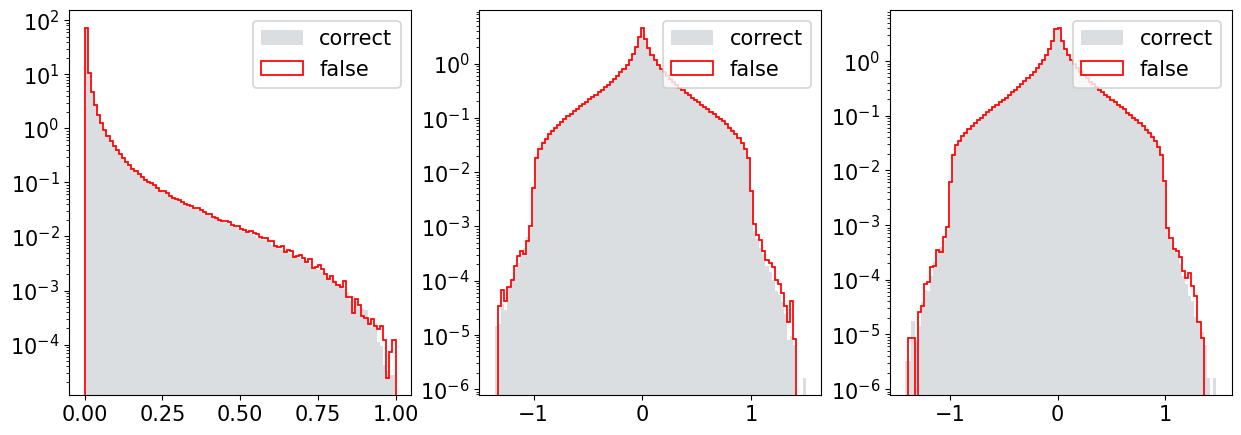

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(false_p[..., i]), np.min(correct_p[...,i])), max(np.max(false_p[..., i]), np.max(correct_p[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=100
    hist = ax.hist(correct_p[..., i].flatten()[correct_p[..., i].flatten() != 0], bins=bins, label="correct", alpha=0.5, density=True)
    hist2 = ax.hist(false_p[..., i].flatten()[false_p[..., i].flatten() != 0], bins=hist[1], label="false", histtype="step", color="red", density=True)
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

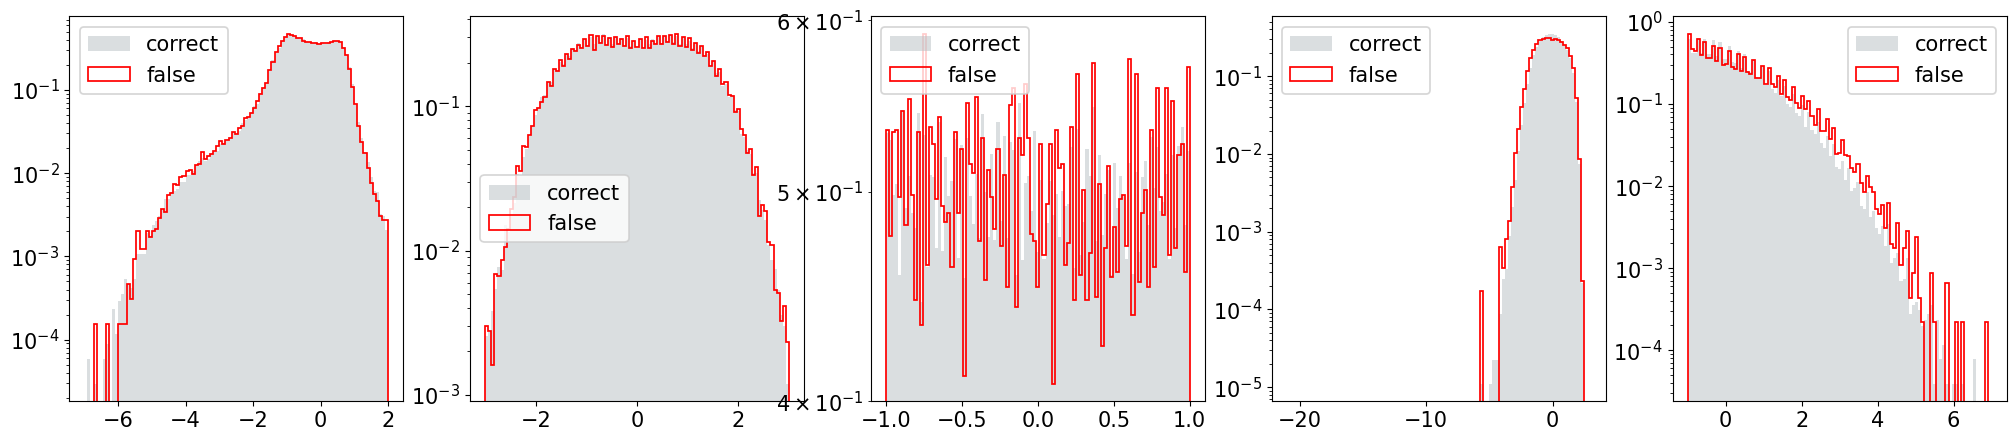

In [70]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axs):
    min_bin, max_bin = min(np.min(false_j[..., i]), np.min(correct_j[...,i])), max(np.max(false_j[..., i]), np.max(correct_j[...,i]))
    bins = np.linspace(int(min_bin), int(max_bin), 100)
    hist = ax.hist(correct_j[..., i].flatten()[correct_j[..., i].flatten() != 0], bins=bins, label="correct", alpha=0.5, density=True)
    hist2 = ax.hist(false_j[..., i].flatten()[false_j[..., i].flatten() != 0], bins=bins, label="false", histtype="step", color="red", density=True)
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

In [71]:
#c_p = correct_p[:len(false_p)]
c_p = correct_p
correct_p_flat = c_p.reshape(c_p.shape[0]*c_p.shape[1], -1)
false_p_flat = false_p.reshape(false_p.shape[0]*false_p.shape[1], -1)

In [72]:
print(correct_p_flat.shape)
print(false_p_flat.shape)

(373180, 837)
(71522, 837)


In [73]:
fig, axs = plt.subplots(93, 9, figsize=(45, 465))
for i, ax in enumerate(axs.flatten()):
    #min_bin, max_bin = min(np.min(false_p_flat[..., i]), np.min(correct_p_flat[...,i])), max(np.max(false_p_flat[..., i]), np.max(correct_p_flat[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(correct_p_flat[...,i].flatten()[correct_p_flat[..., i].flatten() != 0], bins=bins, alpha=0.5, label="correct", histtype="stepfilled", density=True)
    ax.hist(false_p_flat[...,i].flatten()[false_p_flat[..., i].flatten() != 0], bins=hist[1], label="false", histtype="step", density=True)
    #ax.hist(flat_data_v[...,i].flatten()[flat_data_v[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    label=""
    if (i+1) % 3 == 1:
        label += " pt"
        ax.set_yscale("log")
        #print(min_bin, max_bin)
    if (i+1) % 3 == 2:
        label += " eta"
        ax.set_yscale("log")
    if (i+1) % 3 == 0:
        label += " phi"
        ax.set_yscale("log")
    #if i < flat_data_id.shape[-1]//2:
    #    label += " first jet"
    #else:
    #    label += " second jet"
    
    label += f"{(i//3)}"
    #for j in range(particle_data_id.shape[-2]):
    #    if (i+1) % ((j+1)*3) < 0:
    #        label += f" particle {i}"
    ax.set_xlabel(label)
    ax.legend()
plt.tight_layout()
plt.show()

/home/ewencedr/.conda/envs/pllhome/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_48812/3624087699.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")
/tmp/ipykernel_48812/3624087699.py:16: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")
/tmp/ipykernel_48812/3624087699.py:19: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")
